# Process True False Dataset

Dataset from the paper [The Internal State of an LLM Knows When It's Lying](https://aclanthology.org/2023.findings-emnlp.68.pdf)

You can download the dataset [here](http://azariaa.com/Content/Datasets/true-false-dataset.zip).

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize_scalar
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "CPU"
print(f'Device: {device}')

Device: cuda


In [2]:
dataset_name = 'true-false-dataset'
categories = ['animals', 'cities', 'companies', 'elements', 
              'facts', 'generated', 'inventions']

data_path = f'../Data/{dataset_name}'
embeddings_path = f'Embeddings/{dataset_name}'
concepts_path = f'Concepts/{dataset_name}'
cos_sims_path = f'Cosine_Similarities/{dataset_name}'
images_path = f'Images/{dataset_name}'

In [3]:
embeddings_file = os.path.join(embeddings_path, 'embeddings.pt')
    
if os.path.exists(embeddings_file):
    print('Embeddings file found. No need to load model and tokenizer.')
    model = None
    tokenizer = None
else:
    print('Embeddings file NOT found. Loading model and tokenizer...')
    
    from huggingface_hub import notebook_login
    notebook_login()
    
    model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct"
    
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
    model.to(device)
    model.eval()
    print('Done.')

Embeddings file found. No need to load model and tokenizer.


## Processing statements

In [4]:
def get_category(category, data_path):
    cat_path = os.path.join(data_path, f'{category}_true_false.csv')
    df_cat = pd.read_csv(cat_path)
    df_cat[category] = 1
    return df_cat

In [5]:
def get_categories(categories, data_path):
    df_list = []
    for category in categories:
        df_cat = get_category(category, data_path=data_path)
        df_list.append(df_cat)
    metadata_df = pd.concat(df_list, ignore_index=True)
    metadata_df = metadata_df.fillna(0)
    for category in categories:
        metadata_df[category] = metadata_df[category].astype(int)
    metadata_df = metadata_df.rename(columns={'label': 'true'})
    return metadata_df

In [6]:
def get_hidden_states(statements, model, tokenizer, embeddings_path, 
                      device=device, save=True):
    embeddings_file = os.path.join(embeddings_path, 'embeddings.pt')
    
    if os.path.exists(embeddings_file):
        print('   Hidden states file found.')
        hidden_states = torch.load(embeddings_file)
    else:
        print('   Hidden states file NOT found.')
        hidden_states = []
        for statement in tqdm(statements, desc='Getting hidden states'):
            tokenized_prompt = tokenizer(statement, return_tensors="pt").to(device)
            output = model(**tokenized_prompt, output_hidden_states=True)
            
            features = output.hidden_states[-1][0][-1]
            hidden_state = features.cpu().detach()
            hidden_states.append(hidden_state)
            
            del output
            del features
            torch.cuda.empty_cache()

        hidden_states = torch.stack(hidden_states, dim=0)
        # Center embeddings
        average_embedding = torch.mean(hidden_states, 0) 
        centered_hidden_states = hidden_states - average_embedding
        if save:
            os.makedirs(embeddings_path, exist_ok=True)
            torch.save(hidden_states, embeddings_file)
            
    return hidden_states

In [7]:
def process_data(categories, model, tokenizer, data_path, embeddings_path):
    print('Getting statements...', end=' ')
    metadata_df = get_categories(categories, data_path=data_path)
    metadata_df.to_csv(os.path.join(data_path, 'metadata.csv'), index=False)
    statements = metadata_df['statement'].to_list()
    print('Done.')

    print('Getting hidden states...')
    hidden_states = get_hidden_states(statements, model, tokenizer, embeddings_path)
    print('Done.')

    return metadata_df, hidden_states

In [8]:
metadata_df, hidden_states = process_data(categories, model, tokenizer, data_path, embeddings_path)

Getting statements... Done.
Getting hidden states...
   Hidden states file found.
Done.


In [9]:
print(f'Number of statements: {metadata_df.shape[0]}')
print(f'Number of true statements: {metadata_df[metadata_df["true"] == 1].shape[0]}')
print(f'Number of false statements: {metadata_df[metadata_df["true"] == 0].shape[0]}')

Number of statements: 6330
Number of true statements: 3187
Number of false statements: 3143


## Computing concepts

In [10]:
def compute_single_concept(concept, metadata_df, hidden_states):
    # Get embeddings from the concept
    hidden_states_cat = hidden_states[metadata_df[concept]==1] 
    # Get average embedding
    concept_vect = torch.mean(hidden_states_cat, 0) 
    # Normalize vector
    concept_vect = concept_vect / concept_vect.norm() 
    return concept_vect

def compute_concepts(metadata_df, hidden_states, concepts_path, save=True):
    concept_names = list(metadata_df.columns[1:])
    concepts = {}

    print('Computing concept vectors...', end=' ')
    for concept in concept_names:
        concept_vect = compute_single_concept(concept, metadata_df, hidden_states)
        concepts[concept] = concept_vect
    print('Done.')
        
    if save:
        print('Saving concepts...', end=' ')
        os.makedirs(concepts_path, exist_ok=True)
        concepts_path = os.path.join(concepts_path, 'concepts.pt')
        torch.save(concepts, concepts_path)
        print('Done.')

    print(f'Concepts computed: {list(concepts.keys())}')
    return concepts

In [11]:
concepts = compute_concepts(metadata_df, hidden_states, concepts_path)

Computing concept vectors... Done.
Saving concepts... Done.
Concepts computed: ['true', 'animals', 'cities', 'companies', 'elements', 'facts', 'generated', 'inventions']


## Compute cosine similarities

In [12]:
def compute_cosine_sims(hidden_states, concept_embs, concept_names, cos_sims_path,
                        save=True):
    print('Computing cosine similarities...', end=' ')
    similarities = cosine_similarity(hidden_states, concept_embs)
    cosine_similarity_df = pd.DataFrame(similarities, columns=concept_names)
    print('Done.')
    if save:
        print('Saving cosine similarities...', end=' ')
        os.makedirs(cos_sims_path, exist_ok=True)
        cos_sims_df_path = os.path.join(cos_sims_path, 'cosine_similarities.csv')
        cosine_similarity_df.to_csv(cos_sims_df_path, index=False)
        print('Done.')
        
    return cosine_similarity_df

In [13]:
concept_embs = torch.stack(list(concepts.values()), dim=0)
concept_names = list(concepts.keys())
cosine_similarity_df = compute_cosine_sims(hidden_states, concept_embs, concept_names, cos_sims_path)

Computing cosine similarities... Done.
Saving cosine similarities... Done.


In [14]:
def plot_cos_sim_histograms(metadata_df, cosine_similarity_df, images_path):
    concept_names = list(metadata_df.columns[1:])
    fig, axs = plt.subplots(2, 4, figsize=(8,4), sharex=True)
    bins = np.linspace(0, 1, 20)
    for i, concept in enumerate(concept_names):
        ix, iy = int(i/4), i%4
        sns.kdeplot(cosine_similarity_df[metadata_df[concept]==1][concept], 
                    label='In concept', ax=axs[ix,iy])
        sns.kdeplot(cosine_similarity_df[metadata_df[concept]==0][concept], 
                    label='Out of concept', ax=axs[ix,iy])
        axs[ix,iy].set_xlabel('')
        axs[ix,iy].set_ylabel('')
        axs[ix,iy].set_title(concept)
    
    handles, labels = axs[0,0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.2, 0.9))
    xl = fig.supxlabel('Cosine Similarity')
    yl = fig.supylabel('Proportion of samples')
    title = fig.suptitle('Cosine similarity in/out of concept')
    fig.tight_layout()

    print('Saving image...', end=' ')
    os.makedirs(images_path, exist_ok=True)
    cos_sims_image_path = os.path.join(images_path, 'cosine_similarities.png')
    fig.savefig(cos_sims_image_path, bbox_extra_artists=(lgd,xl,yl,title), 
                bbox_inches='tight')
    print('Done.')
    
    plt.show()

Saving image... Done.


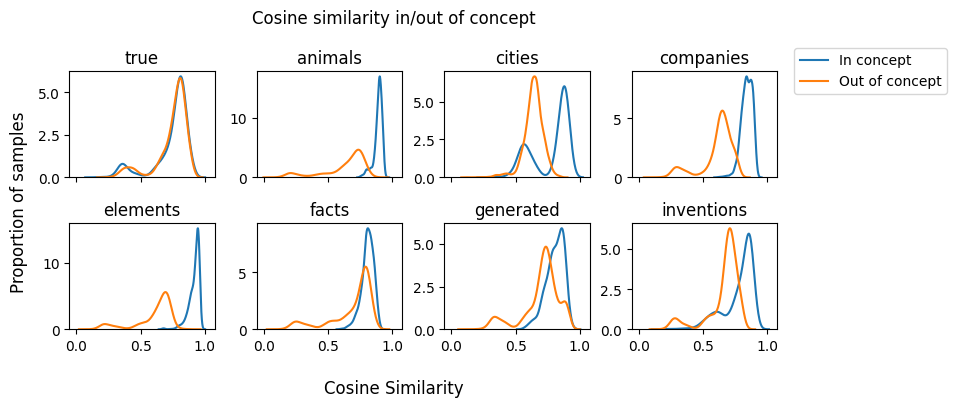

In [15]:
plot_cos_sim_histograms(metadata_df, cosine_similarity_df, images_path)

In [16]:
def show_similarity_concepts(concepts, images_path):
    concept_embs = torch.stack(list(concepts.values()), dim=0)
    concept_names = list(concepts.keys())
    cos_sim_concepts_df = compute_cosine_sims(concept_embs, 
                                              concept_embs, 
                                              concept_names, 
                                              '', save=False)
    cos_sim_concepts_df['Concept'] = list(concepts.keys())
    cos_sim_concepts_df = cos_sim_concepts_df.set_index('Concept')
    ax = sns.heatmap(cos_sim_concepts_df, annot=True, fmt=".2f", cmap="Blues",
               cbar_kws={'label': 'Cosine similarity'})
    ax.set_title('Cosine similarity between concepts')

    print('Saving image...', end=' ')
    os.makedirs(images_path, exist_ok=True)
    cos_sims_image_path = os.path.join(images_path, 'cosine_similarities_concepts.png')
    plt.savefig(cos_sims_image_path)
    print('Done.')
    
    plt.show()

Computing cosine similarities... Done.
Saving image... Done.


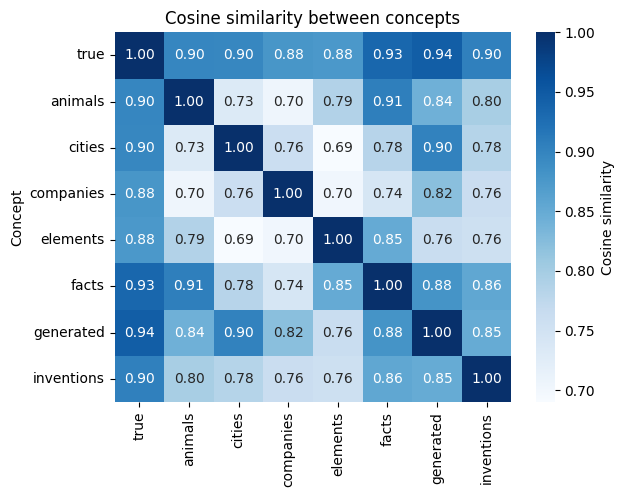

In [17]:
show_similarity_concepts(concepts, images_path)

## Threshold-based models

In [18]:
from models import get_global_threshold, get_individual_thresholds

In [19]:
global_thresh, global_train_error, global_test_errors = get_global_threshold(metadata_df, cosine_similarity_df)
global_test_errors['Model'] = 'Global threshold'

Global threshold: 0.834 | Train error: 0.129
Concept: true       | Test error: 0.484
Concept: animals    | Test error: 0.013
Concept: cities     | Test error: 0.097
Concept: companies  | Test error: 0.082
Concept: elements   | Test error: 0.007
Concept: facts      | Test error: 0.124
Concept: generated  | Test error: 0.160
Concept: inventions | Test error: 0.076


In [20]:
indiv_thresh, indiv_train_errors, indiv_test_errors = get_individual_thresholds(metadata_df, cosine_similarity_df)
indiv_test_errors['Model'] = 'Individual threshold'

Concept: true       | Threshold: -0.528 | Train error: 0.497 | Test error: 0.496
Concept: animals    | Threshold: 0.842 | Train error: 0.019 | Test error: 0.014
Concept: cities     | Threshold: 0.808 | Train error: 0.083 | Test error: 0.088
Concept: companies  | Threshold: 0.782 | Train error: 0.017 | Test error: 0.022
Concept: elements   | Threshold: 0.819 | Train error: 0.008 | Test error: 0.006
Concept: facts      | Threshold: 0.864 | Train error: 0.092 | Test error: 0.093
Concept: generated  | Threshold: 0.933 | Train error: 0.038 | Test error: 0.039
Concept: inventions | Threshold: 0.819 | Train error: 0.067 | Test error: 0.070


In [21]:
error_comparison_df = pd.DataFrame.from_dict([global_test_errors, indiv_test_errors])
error_comparison_df = error_comparison_df.set_index('Model')
error_comparison_df

,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
Global threshold,0.483964,0.013404,0.097176,0.081857,0.007180,0.124461,0.160364,0.075634
Individual threshold,0.496410,0.013882,0.087602,0.022499,0.005744,0.092867,0.038775,0.070369
